In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean

In [3]:
def rev_cumsum(da):
    da = da.assign_coords({"sigma2_l_target": xr.DataArray(da.sigma2_l_target[::-1], dims=("sigma2_l_target",))})
    da = da.isel(sigma2_l_target=slice(None, None, -1)).cumsum("sigma2_l_target")
    da = da.assign_coords({"sigma2_l_target": xr.DataArray(da.sigma2_l_target[::-1], dims=("sigma2_l_target",))})
    da = da.isel(sigma2_l_target=slice(None, None, -1))
    return da

### Water mass drift timeseries

In [13]:
models = ["CM4Xp25", "CM4Xp125"]
mass_in_layer = xr.concat([
    xr.open_dataset(f"../../data/plotting_ready/water_mass_in_density_layer_annualmean_{model}.nc").expand_dims({"model":[model]}).layer_mass
    for model in models
], dim="model")

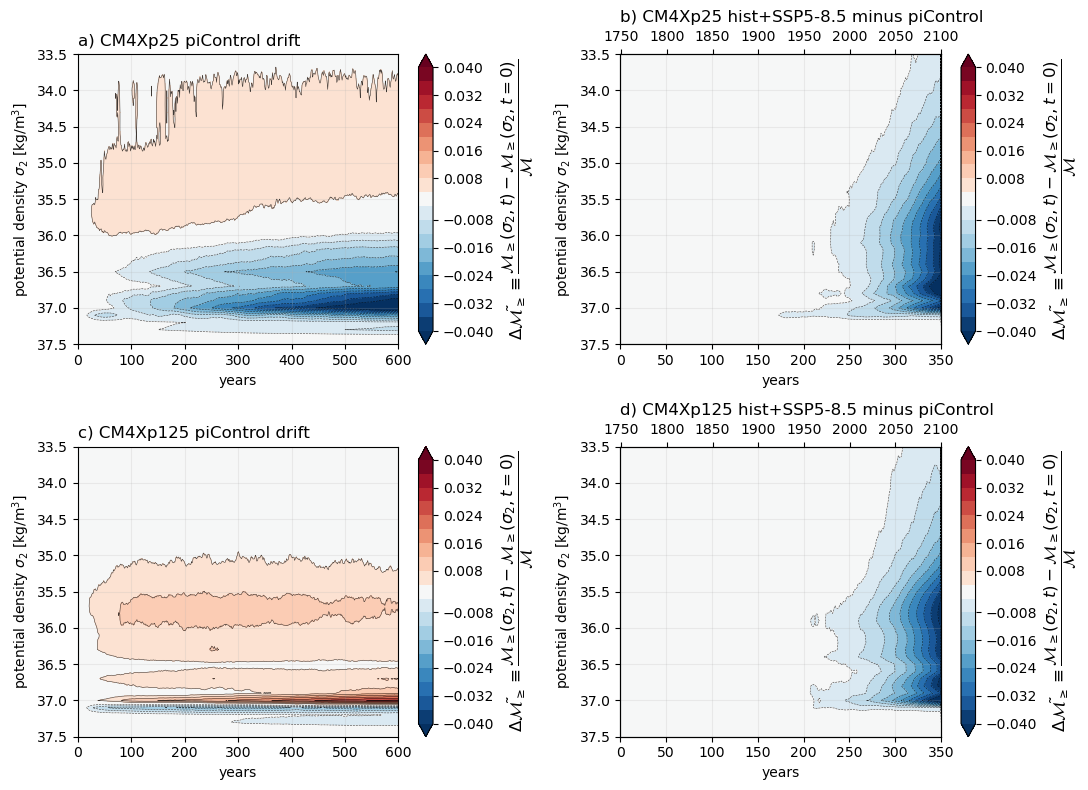

In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

long_labels = {
    "control": "piControl drift",
    "forced": "hist+SSP5-8.5 minus piControl"
}
letter_labels = [["a)", "b)"], ["c)", "d)"]]

def tick_function(x):
    return x+1749

fig, axes = plt.subplots(2,2, figsize=(11,8))
for i, model in enumerate(models):
    for j, exp in enumerate(["control", "forced"]):
        ax = axes[i,j]
        plt.sca(ax)
        if exp=="control":
            CDF_drift = (
                (
                    rev_cumsum(mass_in_layer.sel(model=model, exp=exp)) -
                    rev_cumsum(mass_in_layer.sel(model=model, exp=exp).sel(year=1))
                ) /
                mass_in_layer.sel(model=model, exp="control").sel(year=slice(590, None)).mean("year").sum()
            ).transpose()
        else:
            CDF_drift = (
                (
                    rev_cumsum(mass_in_layer.sel(model=model, exp="forced" )) -
                    rev_cumsum(mass_in_layer.sel(model=model, exp="control"))
                ) /
                mass_in_layer.sel(model=model, exp="control").sel(year=slice(590, None)).mean("year").sum()
            ).transpose()

        vmax = 4e-2
        dlev = 0.4e-2
        levels = np.concatenate((np.arange(-vmax, 0, dlev), np.arange(dlev, vmax+dlev, dlev)))
        label_levels = np.concatenate((np.arange(-vmax, 0, 2*dlev), np.arange(2*dlev, vmax+dlev, 2*dlev)))
        cf = ax.contourf(
            np.arange(0.5, 600, 1),
            mass_in_layer.sigma2_l_target.values,
            CDF_drift,
            cmap="RdBu_r",
            levels=levels,
            vmin=-vmax, vmax=vmax,
            extend="both",
            linestyles="-"
        )
        cb = plt.colorbar(
            cf,
            ticks=label_levels,
        )
        cb.set_label(
            label=r"$\Delta \tilde{\mathcal{M}_{\geq}} \equiv \dfrac{\mathcal{M}_{\geq}(\sigma_{2}, t) - \mathcal{M}_{\geq}(\sigma_{2}, t=0)}{\mathcal{M}}$",
            size=12
        )
        ax.contour(
            np.arange(0.5, 600, 1),
            mass_in_layer.sigma2_l_target.values,
            CDF_drift,
            colors="k",
            levels=levels,
            linewidths=0.4,
            alpha=0.75
        )
        
        if exp == "forced":
            ax.set_xlim(0, 350)
        else:
            ax.set_xlim(0, 600)
        ax.set_ylim(37.5, 33.5)
        ax.set_title(f"{letter_labels[i][j]} {str(model)} {long_labels[str(exp)]}", loc="left")

        ax.grid(True, alpha=0.2)
        ax.set_xlabel("years")
        ax.set_ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]")

        if exp == "forced":
            ax2 = ax.twiny()
            xticks = ax.get_xticks()
            ax2.set_xticks(xticks + 1)
            ax2.set_xticklabels([str(int(e)) for e in tick_function(xticks + 1)])
        if exp == "forced":
            ax.set_xlim(0, 350)
        else:
            ax.set_xlim(0, 600)

plt.tight_layout()
plt.savefig("../../figures/global_wmt_drift", dpi=250, bbox_inches="tight")